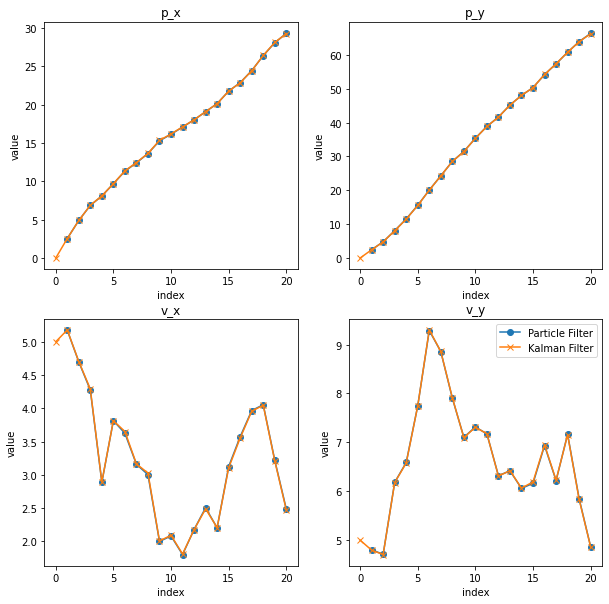

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
def get_weights(Y, samples, cov):
  W = -0.5 * (np.sum((Y - samples) @ np.linalg.inv(cov) * (Y - samples),
                     axis = 1))
  W -= np.max(W)
  W = np.exp(W)
  return W   

# Generate the observations
dy, dx, dt = 4, 4, 0.5
varX, varP, varV = 3, 5, 1
# varX, varP, varV = 0.0003, 0.005, 0.001
N, T = 10000, 20
A = np.array([[1, 0, dt, 0], 
              [0, 1, 0, dt], 
              [0, 0, 1, 0], 
              [0, 0, 0, 1]])
Q = np.array([[0.25 * dt**4, 0, 0.5 * dt**3, 0], 
              [0, 0.25 * dt**4, 0, 0.5 * dt**3], 
              [0.5 * dt**3, 0, dt**2, 0], 
              [0, 0.5 * dt**3, 0, dt**2]])
Q = varX * Q
R = np.array([[varP, 0, 0, 0], 
              [0, varP, 0, 0], 
              [0, 0, varV, 0], 
              [0, 0, 0, varV]])
Y = np.zeros((dy, T))
X = np.zeros((dx, T+1))
X[:, 0] = np.array([0, 0, 5, 5])
for i in range(T):
  W = np.random.multivariate_normal(np.zeros(dx), Q)
  V = np.random.multivariate_normal(np.zeros(dy), R)
  X[:, i + 1] = A @ X[:, i] + W
  Y[:, i] = X[:, i + 1] + V

# Filter
M = np.zeros((dx, T))
for i in range(T):
  # Sampling
  S = np.random.multivariate_normal(np.zeros(dx), Q, size=N)
  if i == 0:
    samples =  A @ X[:, i] + S
  else:
    samples =  np.transpose(A @ prev_samples) + S
  W = get_weights(Y[:, i], samples, R)
  if i != 0:
    W = W * prev_W
  W = W/np.sum(W)

  # Resampling
  ESS = 1/np.sum(W * W)
  if ESS < N/4:
    I = np.random.choice(np.arange(len(W)), size=len(W), p=W)
    samples = samples[I, :]
    W = np.ones(len(W))/len(W)
  # Compute expectation
  M[:, i] = np.transpose(samples) @ W
  prev_samples = np.transpose(samples)
  prev_W = W

# Kalman Filter Algorithm
pred_state = np.zeros((dx, T))
state = np.zeros((dx, T+1))
pred_err = np.zeros((T, dx, dx))
err = np.zeros((T + 1, dx, dx))
state[:, 0] = X[:, 0]
for i in range(T):
  # Prediction step
  pred_state[:, i] = A @ state[:, i]
  pred_err[i, :, :] = A @ err[i, :, :] @ np.transpose(A) + Q
  # Update step
  K = pred_err[i, :, :] @ np.linalg.inv(R + pred_err[i, :, :])
  state[:, i + 1] = pred_state[:, i] + K @ (Y[:, i] - pred_state[:, i])
  #err[i + 1, :, :] = (np.identity(K.shape[0]) - K) @ err[i, :, :]
  err[i + 1, :, :] = (np.identity(K.shape[0]) - K) @ pred_err[i, :, :]

subplotTitles = ["p_x","p_y", "v_x", "v_y"]  
fig, axs = plt.subplots(2, 2, figsize = (10, 10))
for i, ax in zip(range(4), axs.flat):
  ax.set_title(subplotTitles[i])
  ax.plot(range(1, T + 1), M[i, :], '-o', label="Particle Filter")
  # ax.plot(range(0, T + 1), X[i, :], label="X_n")
  # ax.plot(range(1, T + 1), Y[i, :], label="Y_n")
  ax.plot(range(0, T +1), state[i, :], '-x', label="Kalman Filter")

  ax.set(xlabel ="index", ylabel = "value")
 

plt.legend(loc=0)
plt.show()
